In [1]:
import os
import sys
import time
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

from livelossplot import PlotLosses

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import IncrementalPCA

from IPython.display import Image

from tqdm.notebook import tqdm

# Using model code from Stutz et.al.
os.chdir("/data/adv_geom/drg/")
from models.classifier import Classifier
from training.train_classifier import TrainClassifier

[2502211059] [Warning] running without display


In [2]:
class EMNIST(Dataset):
    
    def __init__(self, X, y):
        'Initialization'
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        
        return self.X[idx], self.y[idx]

In [3]:
%tb
args = {
    "train_images_file": "/data/adv_geom/datasets/emnist/train_images.h5",
    "train_codes_file": "/data/adv_geom/datasets/emnist/train_labels.h5",
    "test_images_file": "/data/adv_geom/datasets/emnist/test_images.h5",
    "test_codes_file": "/data/adv_geom/datasets/emnist/test_labels.h5",
    "state_file": "/data/adv_geom/dumps/emnist/classifier.pth.tar",
    "label_index": 0,
    "lr_decay": 0.95,
    "weight_decay": 0.0001,
    "training_samples": 160000,
    "validation_samples": 40000,
    "random_samples": True,
    "network_architecture": "mlp",
    "gpu_id": 1
}

sys.argv = ["-" + i + "=" + str(args[i]) if type(args[i]) != type(True) else "-" + i for i in args]


train_clf = TrainClassifier(args=sys.argv)
train_clf.load_data()
train_clf.load_model_and_scheduler()

No traceback available to show.
[2502211059] -- TrainClassifier
[2502211059] [Training] train_images_file=/data/adv_geom/datasets/emnist/train_images.h5
[2502211059] [Training] train_codes_file=/data/adv_geom/datasets/emnist/train_labels.h5
[2502211059] [Training] test_images_file=/data/adv_geom/datasets/emnist/test_images.h5
[2502211059] [Training] test_codes_file=/data/adv_geom/datasets/emnist/test_labels.h5
[2502211059] [Training] state_file=/data/adv_geom/dumps/emnist/classifier.pth.tar
[2502211059] [Training] log_file=/data/adv_geom/dumps/emnist/classifier.log
[2502211059] [Training] training_file=/data/adv_geom/dumps/emnist/training.h5
[2502211059] [Training] testing_file=/data/adv_geom/dumps/emnist/testing.h5
[2502211059] [Training] loss_file=/data/adv_geom/dumps/emnist/loss.png
[2502211059] [Training] error_file=/data/adv_geom/dumps/emnist/error.png
[2502211059] [Training] gradient_file=/data/adv_geom/dumps/emnist/gradient.png
[2502211059] [Training] label_index=0
[2502211059] 

In [4]:
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


def pgd_linf_rand(model, X, y, epsilon, alpha, num_iter, restarts):
    """ Construct PGD adversarial examples on the samples X, with random restarts"""
    max_loss = torch.zeros(y.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)
    
    for i in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
        
        for t in range(num_iter):
            loss = nn.CrossEntropyLoss()(model(X + delta), y.long())
            loss.backward()
            delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
            delta.grad.zero_()
        
        all_loss = nn.CrossEntropyLoss(reduction='none')(model(X+delta),y.long())
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)
        
    return max_delta

In [5]:
def plot_images(X,y,yp,M,N,path=None):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
#     plt.tight_layout()
    if path is None:
        path = "test.png"
    plt.savefig(path)

In [18]:
def get_projection(x, delta, X_train, nn, pca=None, scheme="paper"):
    """
    get projection of a sample on the approximated manifold
    
    this implementation is based on the repository for Stutz et.al.
    as well as what they have written in their paper
    
    input:
    x: sample for which projection is to be computed (numpy)
    nn: nearest neighbor model fitted on the training samples
    pca: if given it refers to the PCA model fitted on random subset of training samples 
    scheme: 
        - "paper": given in Appendix C in the paper
        - "self": based on paper, computed by myself
        - "pca_paper": nn is done using pca vectors then "paper"
        - "pca_self": nn is done using pca vectors then "self"
    
    returns:
    pi_x: projection of sample onto the manifold
    """
    
    x = x.reshape(1, -1)
    
    # pca is used only in code but not mentioned in the paper
    # if it is provided, we transform the vectors
    if pca:
        assert scheme[:4] == "pca_"
#         assert X_train.shape[1] == pca.n_features_
        x_latent = pca.transform(x)
        
    nbhrs_idx = nn.kneighbors(x_latent.reshape(1, -1), n_neighbors=50)[1][0]
    nbhrs = X_train[nbhrs_idx]
    
    nbhrs = nbhrs.reshape(nbhrs.shape[0], -1)
    delta = delta.reshape(-1)
    
    norm_nbhrs = None
    sol = None
    if "paper" in scheme:
        norm_nbhrs = nbhrs - nbhrs.mean(axis=0)
        print(norm_nbhrs.shape, delta.shape)

        sol = np.linalg.lstsq(norm_nbhrs.T, delta, rcond=None)
    elif "self" in scheme:
        norm_nbhrs = nbhrs - x.reshape(-1) 
        sol = np.linalg.lstsq(norm_nbhrs.T, x, rcond=None)
        
    beta = sol[0]
    pi_x = np.dot(norm_nbhrs.T, beta)
    
    return pi_x
    
    

In [19]:
def get_projections_for_data(X, y, X_train, nn, pca=None, scheme="paper", batch_size=8):
    """get projections for data and get predictions on top of them"""
    
    
    pi_X_set = None
    perturbed_set = None
    
    raw_X_codes = None
    perturbed_X_codes = None
    pi_X_codes = None
    
    
    dataset = EMNIST(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    for (inp, targets) in tqdm(dataloader):
        
        model.cuda()
        inp = inp.cuda()
        
        targets = targets.cuda()
        
        with torch.no_grad():
            raw_pred_codes = model(inp)
        
        
        if raw_X_codes is None:
            raw_X_codes = raw_pred_codes
        else:
            raw_X_codes = torch.cat((raw_X_codes, raw_pred_codes), axis=0)
            
        
        
        delta = pgd_linf_rand(model, inp, targets, 0.1, 1e-2, 40, 10)
        delta = delta.cuda()
        
        perturbed_inp = inp + delta
        
        with torch.no_grad():
            perturbed_pred_codes = model(perturbed_inp)
            
        
        
        inp = inp.cpu()
        targets = targets.cpu()
        delta = delta.cpu()
        
        projected_inp_batch = None
        
        # finding projections
        for i in range(inp.shape[0]):
            
            projected_inp = get_projection(perturbed_inp[i].cpu(), delta[i], X_train, nn, pca, scheme)
            projected_inp = torch.from_numpy(projected_inp)
            
            projected_inp = projected_inp.reshape(28, 28, 1)
            
            
            if pi_X_set is None:
                pi_X_set = projected_inp
            else:
                pi_X_set = torch.cat((projected_inp, projected_inp), axis=0)
                
            if projected_inp_batch is None:
                projected_inp_batch = projected_inp
            else:
                projected_inp_batch = torch.cat((projected_inp_batch, projected_inp), axis=0)
                
        projected_inp_batch = projected_inp_batch.cuda()
        
        with torch.no_grad():
            projected_pred_codes = model(projected_inp_batch)
        
        perturbed_pred_codes = perturbed_pred_codes.cpu()
        perturbed_inp = perturbed_inp.cpu()
        projected_pred_codes = projected_pred_codes.cpu()
        projected_inp_batch = projected_inp_batch.cpu()
        
        if perturbed_set is None:
            perturbed_set = perturbed_inp
        else:
            perturbed_inp = torch.cat((perturbed_set, perturbed_inp), axis=0)
        
        if perturbed_X_codes is None:
            perturbed_X_codes = perturbed_pred_codes
        else:
            perturbed_X_codes = torch.cat((perturbed_X_codes, perturbed_pred_codes), axis=0)
        
        
        if pi_X_codes is None:
            pi_X_codes = projected_pred_codes
            
        else:
            pi_X_codes = torch.cat((pi_X_codes, projected_pred_codes), axis=0)
        
        
        
    return pi_X_set, perturbed_set, raw_X_codes, perturbed_X_codes, pi_X_codes
        
    
# model.cuda()
# rimg = rimg.cuda()
# rcode = rcode.cuda()
# delta = pgd_linf_rand(model, rimg, rcode, 0.1, 1e-2, 40, 10)
# model.cpu()
# rimg = rimg.cpu()
# rcode = rcode.cpu()

In [20]:
model = train_clf.model
X_test = torch.Tensor(train_clf.test_images)
y_test = torch.Tensor(train_clf.test_codes)


In [21]:
"""
Finding nearest neighbours on the manifold
Reference: https://github.com/davidstutz/disentangling-robustness-generalization/blob/220ff8a79a5f08665f4755dc76d4e592ae66c6d6/training/test_attack_classifier.py#L154
"""

'\nFinding nearest neighbours on the manifold\nReference: https://github.com/davidstutz/disentangling-robustness-generalization/blob/220ff8a79a5f08665f4755dc76d4e592ae66c6d6/training/test_attack_classifier.py#L154\n'

In [22]:
X_train = train_clf.train_images
y_train = train_clf.train_codes

USE_PCA = True
num_img_to_fit = 10000

pca = None
NN = None
X_train_latent = None

if USE_PCA:

    # Training a PCA model on randomly sampled 10000 images from the training set
    idx = np.random.randint(0, X_train.shape[0], size=num_img_to_fit)

    pca = IncrementalPCA(n_components=20) # n_components taken from David Stutz's code
    pca.fit(X_train[idx].reshape(X_train[idx].shape[0], -1))

    # Transforming the training set based on the learned PCA model 
    # Note: These will be used to approximate the manifold, since these
    # are what the classifier has been trained on
    X_train_latent = pca.transform(X_train.reshape(X_train.shape[0], -1))

    # Fitting a Nearest Neighbors object on the transformed latent samples
    NN = NearestNeighbors(n_neighbors=50, algorithm='kd_tree')
    NN.fit(X_train_latent)
    
else:
    NN = NearestNeighbors(n_neighbors=50, algorithm="kd_tree")
    NN.fit(X_train.reshape(X_train.shape[0], -1))

In [23]:
pi_X_set, perturbed_set, raw_X_codes, perturbed_X_codes, pi_X_codes = get_projections_for_data(X_test,\
                                                                                               y_test,\
                                                                                               X_train,\
                                                                                               NN,\
                                                                                               pca,\
                                                                                               scheme="pca_paper",\
                                                                                               batch_size=8)






(50, 784) torch.Size([784])


RuntimeError: shape '[784, 28, 28, 1]' is invalid for input of size 784

In [32]:
# Pick a perturbed sample
ridx = np.random.randint(0, X_test.shape[0], size=(1,6))[0]
rimg = X_test[ridx]
rcode = y_test[ridx]

In [34]:
plt.figure()
plt.imshow(X_test[ridx][0], cmap="gray")
plt.savefig("raw.png")

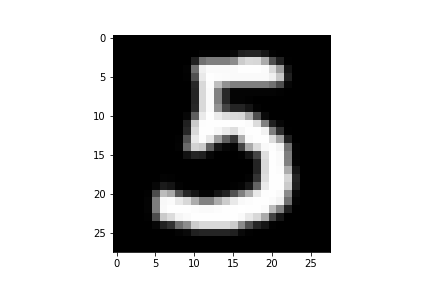

In [35]:
Image(filename='raw.png')

In [36]:
rimg = torch.Tensor(rimg)
rcode = torch.Tensor(rcode)

In [37]:
model.cuda()
rimg = rimg.cuda()
rcode = rcode.cuda()
delta = pgd_linf_rand(model, rimg, rcode, 0.1, 1e-2, 40, 10)
model.cpu()
rimg = rimg.cpu()
rcode = rcode.cpu()


In [38]:
model.cuda()
with torch.no_grad():
    
    yp = model(rimg.cuda() + delta.cuda())
    
    model.cpu()

In [39]:
# X = torch.Tensor(train_clf.train_images)
# y = torch.Tensor(train_clf.train_codes).long()
# model.cuda()
# X = X.cuda()
# y = y.cuda()
# delta = pgd_linf_rand(model, X[:1], y[:1], 0.1, 1e-2, 40, 10)
# model.cpu()
# X = X.cpu()
# y = y.cpu()

In [40]:
yp.shape, rimg.shape, rcode.shape

(torch.Size([6, 10]), torch.Size([6, 28, 28, 1]), torch.Size([6]))

In [41]:
X = rimg.numpy()
X = X.reshape(X.shape[0], -1)[0]
X.shape

(784,)

In [73]:
rimg.shape

torch.Size([6, 28, 28, 1])

torch.Size([6, 1, 28, 28])

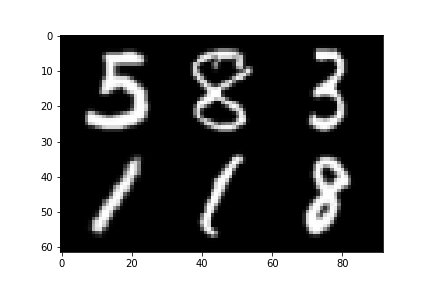

In [77]:
toplot = rimg.permute(0, 3, 1, 2)
grid_img = torchvision.utils.make_grid(toplot, nrow=3)
plt.imshow(grid_img.permute(1, 2, 0))
plt.savefig("test_grid.png")
Image(filename="test_grid.png")

In [42]:
delta = delta.cpu().numpy()[0]
delta.shape

(28, 28, 1)

In [43]:
delta = delta.reshape(-1)
delta.shape

(784,)

In [44]:
X_query = None
if USE_PCA:
    X_query = pca.transform((X + delta).reshape(1, -1))
else:
    X_query = (X + delta).reshape(1, -1)
X_query.shape

(1, 784)

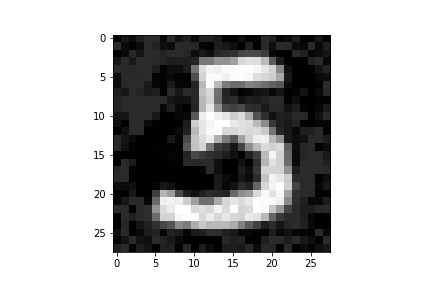

In [45]:
plt.figure()
plt.imshow((X + delta).reshape((28, 28, 1)), cmap="gray")
plt.savefig("perturbed.png")

Image(filename="perturbed.png")

In [120]:
knbhrs = NN.kneighbors(X_query.reshape(1, -1), n_neighbors=50)[1][0]


In [121]:
X_query.shape

(1, 784)

In [122]:
X_knbhrs = X_train[knbhrs].reshape(knbhrs.shape[0], -1)
X_knbhrs.shape

(50, 784)

In [123]:
A = X_knbhrs - np.mean(X_knbhrs, axis=0)


In [124]:
A.shape, delta.shape

((50, 784), (784,))

In [134]:
# sol = np.linalg.lstsq(A.T, delta, rcond=None)
sol = np.linalg.lstsq(A.T, delta, rcond=None)

In [145]:
beta = sol[0]
pi_X = np.dot(A.T, beta)
pi_X.shape

(784,)

In [136]:
plt.figure()
plt.imshow(pi_X.reshape((28, 28, 1)), cmap="gray")
plt.savefig("projection2.png")

# plt.figure()
# plt.imshow(X_train[ridx][0], cmap="gray")
# plt.savefig("test2.png")

In [137]:
pi_X = torch.from_numpy(pi_X.reshape((28, 28, 1))).cuda()
inp = pi_X.repeat(3, 1, 1, 1)
inp2 = torch.from_numpy((X + delta).reshape(-1, 28, 28, 1)).cuda().repeat(3, 1, 1, 1)

In [138]:
model.cuda()
logits = model(inp)
model.cpu()
pi_X = pi_X.cpu()
inp = inp.cpu()
inp2 = inp2.cpu()
torch.max(logits, axis=1)

torch.return_types.max(
values=tensor([-3.5736, -3.5736, -3.5736], device='cuda:1', grad_fn=<MaxBackward0>),
indices=tensor([8, 8, 8], device='cuda:1'))

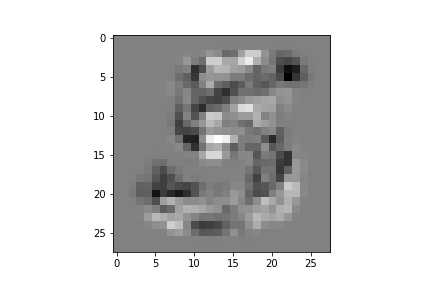

In [139]:
from IPython.display import Image
Image(filename='projection2.png') 

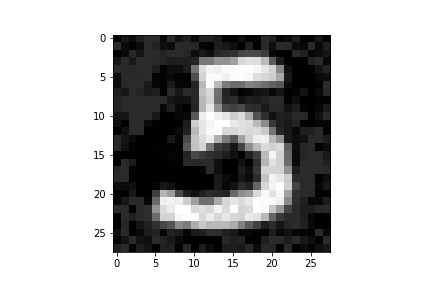

In [131]:
Image(filename='perturbed.png')

In [133]:
inp.shape

torch.Size([3, 28, 28, 1])

In [153]:
(X + delta).reshape(28, 28, 1) - pi_X

array([[[-0.1       , -0.1       , -0.1       , ..., -0.1       ,
         -0.1       , -0.1       ],
        [ 0.01000001,  0.01000001,  0.01000001, ...,  0.01000001,
          0.01000001,  0.01000001],
        [-0.04012454, -0.04012454, -0.04012454, ..., -0.04012454,
         -0.04012454, -0.04012454],
        ...,
        [-0.09      , -0.09      , -0.09      , ..., -0.09      ,
         -0.09      , -0.09      ],
        [ 0.01041594,  0.01041594,  0.01041594, ...,  0.01041594,
          0.01041594,  0.01041594],
        [-0.1       , -0.1       , -0.1       , ..., -0.1       ,
         -0.1       , -0.1       ]],

       [[ 0.1       ,  0.1       ,  0.1       , ...,  0.1       ,
          0.1       ,  0.1       ],
        [-0.04000001, -0.04000001, -0.04000001, ..., -0.04000001,
         -0.04000001, -0.04000001],
        [-0.1       , -0.1       , -0.1       , ..., -0.1       ,
         -0.1       , -0.1       ],
        ...,
        [ 0.1       ,  0.1       ,  0.1       , ...,  

In [162]:
a = torch.randint(0, 3, size=(1, 3, 3, 1))

In [167]:
a.shape

torch.Size([1, 3, 3, 1])

In [168]:
torch.cat((a, a, a), axis=0).shape

torch.Size([3, 3, 3, 1])